In [15]:
from importlib import reload
import sys
import pickle
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pybedtools
from matplotlib_venn import venn2
import gseapy
from gseapy.parser import Biomart
from gseapy.plot import barplot

## Load data

In [64]:
active_loci_dir = '/home/braunger/masterthesis/save/active_loci/'
genome_dir = '/home/braunger/masterthesis/data/genome_data/'
mofa_dir = '/home/braunger/masterthesis/save/'
save_dir = '/home/braunger/masterthesis/save/figures/active_loci_comparison/'

In [65]:
# Active loci per cell type
IMR90 = pd.read_csv(active_loci_dir + "IMR90_cosine_all_features.txt")["0"].tolist()
old_fibroblasts = pd.read_csv(active_loci_dir + "old_fibroblasts_cosine_all_features.txt")["0"].tolist()

# Annotation of corresponding loci for each gene
genes_loci = pd.read_csv(genome_dir + "genes_loci.csv")
genes_loci

,locus,gene
0,chr_1_loc_0,ENST00000456328
1,chr_1_loc_0,ENST00000515242
2,chr_1_loc_0,ENST00000518655
3,chr_1_loc_0,ENST00000450305
4,chr_1_loc_0,ENST00000438504
...,...,...
189908,chr_22_loc_51000000,ENST00000494075
189909,chr_22_loc_51000000,ENST00000423888
189910,chr_22_loc_51000000,ENST00000480246
189911,chr_22_loc_51000000,ENST00000427528


## Intersections of active loci

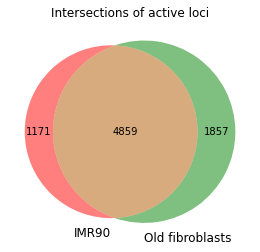

In [4]:
venn2(subsets = [set(IMR90), set(old_fibroblasts)], 
      set_labels = ('IMR90', 'Old fibroblasts'), alpha = 0.5)
plt.title("Intersections of active loci")
plt.savefig(save_dir+'venn_active_loci_comparison.png')

### GSEA on old-specific active loci

In [43]:
old_fibroblasts_specific = [x for x in old_fibroblasts if x not in IMR90]
old_genes = genes_loci.loc[genes_loci["locus"].isin(old_fibroblasts_specific) , "gene"].tolist()
print(old_genes[0:5])
print(len(old_genes))

['ENST00000424215', 'ENST00000493183', 'ENST00000474659', 'ENST00000419916', 'ENST00000378424']
15137


In [51]:
# Use Biomart to translate from ensemble gene id to gene name
bm = Biomart()
## query results
results = bm.query(dataset='hsapiens_gene_ensembl',
                   attributes=['ensembl_transcript_id', 'external_gene_name'],
                   filters={'ensembl_transcript_id': old_genes})
results

,ensembl_transcript_id,external_gene_name
0,ENST00000516570,U6
1,ENST00000393394,NaN
2,ENST00000395385,ZNF676
3,ENST00000540591,PRAMEF18
4,ENST00000363400,Y_RNA
...,...,...
13336,ENST00000359637,CFH
13337,ENST00000470918,CFH
13338,ENST00000367429,CFH
13339,ENST00000496761,CFH


In [52]:
old_specific_genes = np.unique(np.array(results["external_gene_name"].tolist())).tolist()
len(old_specific_genes)

4080

In [56]:
# GSEA of old-specific genes
enr = gseapy.enrichr(gene_list=old_specific_genes, gene_sets='GO_Biological_Process_2018', organism='Human',
                     description='old_specific', outdir='gsea_top_hic',format='png',
                     verbose=False)
print(len(enr.results))

/home/braunger/miniconda3/envs/hic/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


3330


In [57]:
# Visualize results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,peptide cross-linking (GO:0018149),23/47,0.000012,0.038592,0,0,3.754909,42.676197,SPRR4;SPRR3;KRT2;KRT1;F13A1;LCE1E;LCE1F;LCE2D;...
1,GO_Biological_Process_2018,keratinocyte differentiation (GO:0030216),22/59,0.002044,0.999996,0,0,2.327241,14.412369,SPRR4;SPRR3;ST14;AKR1C3;LCE1E;LCE1F;LCE1C;LCE2...
2,GO_Biological_Process_2018,epidermal cell differentiation (GO:0009913),24/67,0.002457,0.999996,0,0,2.184808,13.128518,SPRR4;SPRR3;ST14;SPINK5;AKR1C3;LCE1E;LCE1F;LCE...
3,GO_Biological_Process_2018,natural killer cell activation involved in imm...,10/20,0.003014,0.999996,0,0,3.909091,22.690809,IFNA4;IFNA7;IFNA14;IFNA16;IFNB1;IFNA17;KLRF2;I...
4,GO_Biological_Process_2018,regulation of peptidyl-serine phosphorylation ...,9/18,0.004870,0.999996,0,0,3.908376,20.810888,IFNA4;IFNA7;IFNA14;IFNA16;IFNB1;IFNA17;IFNW1;I...


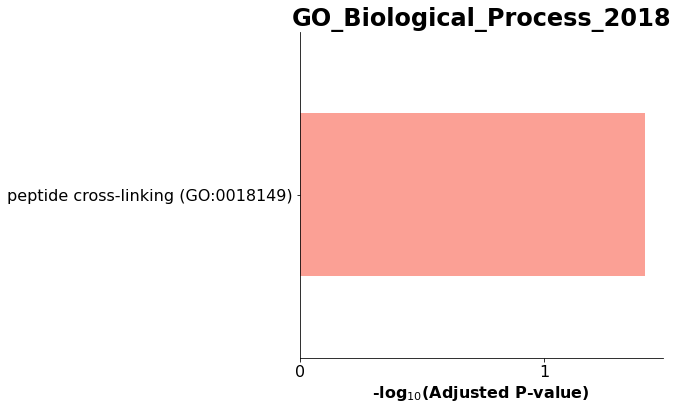

In [63]:
# Barplot
barplot(enr.res2d, column='Adjusted P-value', title='GO_Biological_Process_2018',
        cutoff=0.05, top_term=20, figsize=(6.5, 6), color='salmon', ofname=None)

### GSEA on IMR90 specific active loci

In [44]:
IMR90_specific = [x for x in IMR90 if x not in old_fibroblasts]
IMR90_genes = genes_loci.loc[genes_loci["locus"].isin(IMR90_specific) , "gene"].tolist()
print(IMR90_genes[0:5])
print(len(IMR90_genes))

['ENST00000511072', 'ENST00000442529', 'ENST00000441472', 'ENST00000378398', 'ENST00000607632']
24719


In [53]:
# Use Biomart to translate from ensemble gene id to gene name
bm = Biomart()
## query results
results_IMR90 = bm.query(dataset='hsapiens_gene_ensembl',
                   attributes=['ensembl_transcript_id', 'external_gene_name'],
                   filters={'ensembl_transcript_id': IMR90_genes})
results_IMR90

,ensembl_transcript_id,external_gene_name
0,ENST00000294916,MT2P1
1,ENST00000535188,NaN
2,ENST00000601863,NaN
3,ENST00000313038,LAIR1
4,ENST00000340373,OR6W1P
...,...,...
22562,ENST00000410856,RNU2-38P
22563,ENST00000531288,NaN
22564,ENST00000532137,NaN
22565,ENST00000364829,RNVU1-24


In [46]:
IMR90_specific_genes = np.unique(np.array(results_IMR90["external_gene_name"].tolist())).tolist()
len(IMR90_specific_genes)

4800

In [47]:
# GSEA of IMR90-specific genes
enr_IMR90 = gseapy.enrichr(gene_list=IMR90_specific_genes, gene_sets='GO_Biological_Process_2018', organism='Human',
                     description='IMR90_specific', outdir='gsea_top_hic',format='png',
                     verbose=False)
print(len(enr_IMR90.results))

/home/braunger/miniconda3/envs/hic/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2022-04-20 11:07:06,390 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


4388


In [48]:
# Visualize results
enr_IMR90.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,positive regulation of tumor necrosis factor s...,7/11,0.005923,0.999996,0,0,5.548300,28.456921,IFIH1;ORM1;FZD5;DDX58;WNT5A;LGALS9;ORM2
1,GO_Biological_Process_2018,cellular response to gonadotropin stimulus (GO...,5/7,0.010708,0.999996,0,0,7.923879,35.948862,LHCGR;NOTCH1;PAX8;FSHR;NSMF
2,GO_Biological_Process_2018,positive regulation of histone H3-K4 methylati...,7/13,0.019441,0.999996,0,0,3.698380,14.573077,KMT2E;PAXIP1;SNW1;AUTS2;DNMT3B;CTNNB1;WDR61
3,GO_Biological_Process_2018,regulation of dendritic spine development (GO:...,13/31,0.020794,0.999996,0,0,2.290532,8.871482,EPHA4;MEF2C;FXR1;ARHGAP44;SIPA1L1;CDK5;DLG5;NE...
4,GO_Biological_Process_2018,acylglycerol homeostasis (GO:0055090),10/22,0.022383,0.999996,0,0,2.642310,10.039372,SCARB1;MLXIPL;HNF4A;ANGPTL3;LPL;APOA1;APOC3;AP...


In [50]:
# Barplot
barplot(enr_IMR90.res2d, column='Adjusted P-value', title='GO_Biological_Process_2018',
        cutoff=0.1, top_term=20, figsize=(6.5, 6), color='salmon', ofname=None)

'Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.1'